Psi_0= [[0.]
 [0.]
 [1.]
 [0.]]
<Psi|H|Psi>= [[1.35714286+0.j]]
<Psi|H|Psi>= [[1.1186252+0.j]]
<Psi|H|Psi>= [[1.04533617+0.j]]
<Psi|H|Psi>= [[0.9764367+0.j]]
<Psi|H|Psi>= [[0.90801952+0.j]]
<Psi|H|Psi>= [[0.84103708+0.j]]
<Psi|H|Psi>= [[0.77664279+0.j]]
<Psi|H|Psi>= [[0.7159483+0.j]]
<Psi|H|Psi>= [[0.65989149+0.j]]
<Psi|H|Psi>= [[0.60914438+0.j]]
<Psi|H|Psi>= [[0.5640716+0.j]]
<Psi|H|Psi>= [[0.52473816+0.j]]
<Psi|H|Psi>= [[0.49095437+0.j]]
<Psi|H|Psi>= [[0.46234109+0.j]]
<Psi|H|Psi>= [[0.43839926+0.j]]
<Psi|H|Psi>= [[0.41857223+0.j]]
<Psi|H|Psi>= [[0.40229486+0.j]]
<Psi|H|Psi>= [[0.38902783+0.j]]
<Psi|H|Psi>= [[0.37827851+0.j]]
<Psi|H|Psi>= [[0.36961134+0.j]]
<Psi|H|Psi>= [[0.36265053+0.j]]
<Psi|H|Psi>= [[0.35707791+0.j]]
<Psi|H|Psi>= [[0.35262808+0.j]]
<Psi|H|Psi>= [[0.3490821+0.j]]
<Psi|H|Psi>= [[0.34626104+0.j]]
<Psi|H|Psi>= [[0.34401962+0.j]]
<Psi|H|Psi>= [[0.34224062+0.j]]
<Psi|H|Psi>= [[0.34082981+0.j]]
<Psi|H|Psi>= [[0.33971172+0.j]]
<Psi|H|Psi>= [[0.33882609+0.j]]
Psi_f= [[ 0.0

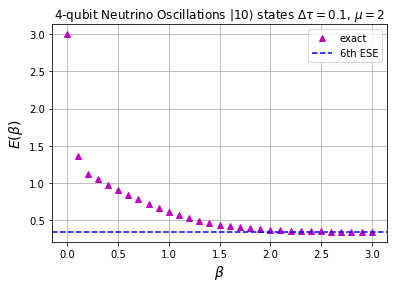

In [2]:
#QITE Exact 
import numpy as np
# import qutip as qt
from matplotlib import pyplot as plt
%matplotlib inline 
import scipy as sp
import scipy.linalg as sl
import scipy.linalg
from scipy.sparse.linalg import cg, expm


from openfermion.ops import QubitOperator as qo
from openfermion.transforms import get_sparse_operator as gso
from openfermion.utils import (trotter_operator_grouping,
                               trotterize_exp_qubop_to_qasm,
                               get_ground_state,
                               sparse_eigenspectrum,
                               hermitian_conjugated as hc)

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
from qiskit.circuit import Parameter
from qiskit import IBMQ
from qiskit.providers.aer import noise
from qiskit.tools.visualization import plot_histogram
import qiskit_functions_noise
#import qiskit_functions #for the hardware runs use this one


# Define Pauli matrices using OpenFermion
mylist = ['X','Y','Z']
# sigmaz = lambda i: qo('Z'+str(i))
sigma = lambda a, i: qo(str(a)+str(i))
sigmaI0sigmaI1= lambda a,i,b,j:qo(str(a)+str(i)+str(' ')+str(b)+str(j))


# Define matrices b_I and S_{IJ}

def b_i0_i1(m,Psi):
    
    b_matrix=[]
    Delta0 =lambda m, Psi: complex(np.matrix(Psi).H@H[m]@Psi)*Psi-H[m]@Psi
    for a in mylist:
        for b in mylist:
            sigmasigmaPsi = np.dot(gso(sigmaI0sigmaI1(a,0,b,1)).todense(),Psi)
            sigmasigmahcDelta0 = np.dot(gso(sigmaI0sigmaI1(a,0,b,1)).todense().H,Delta0(m,Psi))
            b_matrix.append(-1j * np.dot(Psi.T,sigmasigmahcDelta0)+ 1j * np.dot(Delta0(m,Psi).T,sigmasigmaPsi))
    # my b is -b of Eq.(11) in paper
    b_matrix = np.reshape(np.array(b_matrix),(3**(D+1),1))
    return b_matrix

def S_i0_i1_j0_j1(m, Psi):
    S_matrix = []

    for a in mylist:
        for b in mylist:
            for c in mylist:
                for d in mylist:
#                 print(np.dot(sigmaI0sigmaI1(a,0,b,1),sigmaI0sigmaI1(c,0,d,1)))
                    S_matrix.append(np.dot(np.dot(Psi.T,gso(sigmaI0sigmaI1(a,0,b,1)).todense().H)
                     ,np.dot(gso(sigmaI0sigmaI1(c,0,d,1)).todense(),Psi)))

    S_matrix = np.reshape(S_matrix, (3**(D+1), 3**(D+1)))
    return S_matrix

StransS = lambda m, Psi:S_i0_i1_j0_j1(m, Psi).T + S_i0_i1_j0_j1(m, Psi)

# Solving for a[m] using conjugate gradient method
a_i0_i1 = lambda m, Psi:cg(StransS(m, Psi), -b_i0_i1(m, Psi))


aa=[sigmaI0sigmaI1(a,0,b,1) for a in mylist for b in mylist]
def A_operator(m, Psi):
    A_el = []
    for i in range(0,len(a_i0_i1(m, Psi)[0])):
        if abs(a_i0_i1(m, Psi)[0][i]) > 0:
            A_el.append(a_i0_i1(m, Psi)[0][i]*aa[i])
#             print(A_el)
    return np.sum(A_el)

#Define how to calculate the energy expectation values
def exp_val(m, Psi): #be careful, if H has 2 terms m=2 but the terms are h[0] and h[1]
    energy = 0
    for i in range(0,m):
        energy = energy + np.matrix(Psi).H@H[i]@Psi
    return energy


#defining functions for single-step approximation
def b_i0_i1_i2_i3_beta(m,Psi,beta):
    
    b_matrix=[]
    Delta0 =lambda m, Psi: (Psi-Psi0)/beta
    for a in mylist:
        for b in mylist:
            for c in mylist:
                for d in mylist:
                    sigmasigmaPsi = np.dot(gso(sigmaI0sigmaI1sigmaI2sigmaI3(a,0,b,1,c,2,d,3)).todense(),Psi)
                    sigmasigmahcDelta0 = np.dot(gso(sigmaI0sigmaI1sigmaI2sigmaI3(a,0,b,1,c,2,d,3)).todense().H,Delta0(m,Psi))
                    b_matrix.append(-1j * np.dot(Psi.T,sigmasigmahcDelta0)+ 1j * np.dot(Delta0(m,Psi).T,sigmasigmaPsi))# my b is -b of Eq.(11) in paper
    b_matrix = np.reshape(np.array(b_matrix),(3**(D+1),1))
    return b_matrix
# Solving for a[m] using conjugate gradient method
a_i0_i1_i2_i3_beta = lambda m, Psi,beta:cg(StransS(m, Psi), -b_i0_i1_i2_i3_beta(m, Psi,beta))


def A_operator_beta(m, Psi,beta):
    A_el = []
    for i in range(0,len(a_i0_i1_i2_i3_beta(m, Psi,beta)[0])):
        if abs(a_i0_i1_i2_i3_beta(m, Psi,beta)[0][i]) > 0:
            A_el.append(a_i0_i1_i2_i3_beta(m, Psi, beta)[0][i]*aa[i])
#             print(A_el)
    return np.sum(A_el)

##############################################################
########HERE ARE THE PARAMETERS TO CHANGE FOR QITE############
##############################################################
#Define parameters
D = 1 # the number of qubits is D+1
Deltatau = 0.1
num_steps = 30 # determines how far you want to go in QITE. 
num_qubits = 2
# Define states
Zero = np.array([[1.0],
                 [0.0]])
One = np.array([[0.0],
                [1.0]])
initial_state = np.kron(One,Zero)

#Define the Hamiltonian h[m]
omega0 = 1.055e-16 #MeV
mu =2.0 #at r=R_\nu in terms of omega0
omega = lambda p: p #in terms of omega0
filename = '4to2QubitNeutrinoOscillations10_1_1_StatesDeltatau0p1mu2'
#############################################################
#############################################################
Ham_4qubit = mu/4*(2*np.kron(np.kron(gso(qo('X0 X1')).todense(),np.identity(2)),np.identity(2))\
             +2*np.kron(np.kron(gso(qo('Y0 Y1')).todense(),np.identity(2)),np.identity(2))\
           +2*np.kron(np.kron(gso(qo('Z0 Z1')).todense(),np.identity(2)),np.identity(2))\
           +2*np.kron(gso(qo('X0 X2')).todense(),np.identity(2))+2*np.kron(gso(qo('Y0 Y2')).todense(),np.identity(2))\
             +2*np.kron(gso(qo('Z0 Z2')).todense(),np.identity(2))\
           +2*np.kron(gso(qo('X1 X2')).todense(),np.identity(2))+2*np.kron(gso(qo('Y1 Y2')).todense(),np.identity(2))\
             +2*np.kron(gso(qo('Z1 Z2')).todense(),np.identity(2))\
             +2*gso(qo('X0 X3')).todense()+2*gso(qo('Y0 Y3')).todense()+2*gso(qo('Z0 Z3')).todense()\
           +2*gso(qo('X1 X3')).todense()+2*gso(qo('Y1 Y3')).todense()+2*gso(qo('Z1 Z3')).todense()\
             +2*gso(qo('X2 X3')).todense()+2*gso(qo('Y2 Y3')).todense()+2*gso(qo('Z2 Z3')).todense()\
           +12*np.identity(16))-(omega(1)*np.kron(np.kron(np.kron(gso(qo('Z0')).todense(),np.identity(2)),np.identity(2)),np.identity(2))\
        +omega(2)*np.kron(np.kron(gso(qo('Z1')).todense(),np.identity(2)),np.identity(2))\
        +omega(3)*np.kron(gso(qo('Z2')).todense(),np.identity(2))\
                                +omega(4)*gso(qo('Z3')).todense())/2
Ham_4to2qubit=[]
for i in [1,2,4,8]:
    for j in [1,2,4,8]:
        Ham_4to2qubit.append(Ham_4qubit[i,j])
# print(np.reshape(Ham_4to2qubit,(4,4)))
H = [ np.reshape(Ham_4to2qubit,(4,4)) #this Hamiltonian is for single 1 cases, |1000>, |0100>, |0010>, |0001>
     ]#making Z0 (4x4)


Ham = np.reshape(Ham_4to2qubit,(4,4))

A_operators = []
exp_vals = []
beta = []
exact_val = []

Psi = initial_state
Psi = Psi/np.sqrt(Psi.T@Psi) #normalizing the state
# print("A_0","1=",A_operator(0,Psi))
print("Psi_0=",Psi)
exp_vals.append(exp_val(1,Psi))
exact_val.append(exp_val(1,Psi))
beta.append(0)
Phi = []
for i in range(1,num_steps+1):
#     print("A_",i,"1=",A_operator(0,Psi))
    #A_operators.append(A_operator(0, Psi))
    Psi = (np.identity(4)-1j*Deltatau*gso(A_operator(0,Psi)).todense())@Psi
    Psi = Psi/np.sqrt(Psi.T@Psi) #normalizing the state
#     print("A_",i,"2=",A_operator(1,Psi))
#     Psi = (np.identity(8)-1j*Deltatau*gso(A_operator(1,Psi)).todense())@Psi
#     Psi = Psi/np.sqrt(Psi.T@Psi)
#     print("A_",i,"3=",A_operator(2,Psi))
#     Psi = (np.identity(8)-1j*Deltatau*gso(A_operator(2,Psi)).todense())@Psi
#     Psi = Psi/np.sqrt(Psi.T@Psi)
    Phi.append(Psi)
#     print("Phi_",i,"=",Phi[i-1])
    exp_vals.append(exp_val(1, Psi))
    print("<Psi|H|Psi>=",exp_val(1, Psi))
    beta.append((i)*Deltatau)
# plt.figure(1, figsize=(10, 5))
print("Psi_f=",Psi)
print("beta=",beta)
print("energy values = ",np.reshape(np.real(exp_vals),(num_steps+1)))
plt.plot(beta, np.reshape(np.real(exp_vals),(num_steps+1)),"m^", label = r"exact")
plt.title(r"4-qubit Neutrino Oscillations $|10\rangle$ states $\Delta \tau=0.1$, $\mu=2$")
plt.axhline(y=sl.eig(Ham)[0][3].real, color='b', linestyle='--', label = "6th ESE")
# plt.ylim(-2,1)
# plt.xlim(-0.1,3.1)
plt.xlabel(r'$\beta$ ',fontsize = 14)
plt.ylabel(r'$E(\beta)$',fontsize = 14)
#plt.title('title')
plt.grid(True)
plt.legend(loc = "best")
#plt.legend(loc = "upper right",mode = "expand",ncol=5)
#plt.savefig("test.pdf")
plt.show()

#### End of QITE###

#newPhi=[]
#for i in range(0,len(Phi)):
#    newPhi.append(np.array(Phi[i].real))
#import pandas as pd
#PhiList = [newPhi]
#Phi_list = np.array(PhiList)
#Phi_list.shape = -1, 2**num_qubits # reshape it
#pd.DataFrame(Phi_list).to_csv('Phis'+filename+'.csv')
#pd.DataFrame(np.reshape(np.real(exp_vals),(num_steps+1))).to_csv(filename + 'exactenergyvals.csv')
#energy_vals = pd.read_csv(filename + 'exactenergyvals.csv').values

Exact calculated energies for QITE steps
energy values =  [3.         1.34469417 1.13648937 1.07185968 1.00891839 0.9445734
 0.87983973 0.81600133 0.75439127 0.69624183 0.64255832 0.59403798
 0.55104322 0.51362381 0.48157333 0.4545014  0.4319062  0.41323679
 0.39794038 0.38549441 0.37542518 0.36731643 0.36081083 0.35560712
 0.35145481 0.34814783 0.34551816 0.34342961 0.34177246 0.34045861
 0.33941759 0.33859313 0.33794043 0.33742388 0.33701516 0.33669183
 0.33643609 0.33623384 0.33607389 0.33594742 0.33584742 0.33576835]


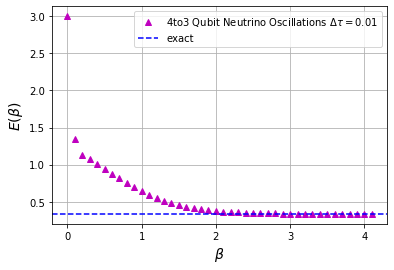

41


In [3]:
import numpy as np
# import qutip as qt
from matplotlib import pyplot as plt
%matplotlib inline 
import scipy as sp
import scipy.linalg as sl
import scipy.linalg
from scipy.sparse.linalg import cg, expm
import pandas as pd
import warnings

from openfermion.ops import QubitOperator as qo
from openfermion.transforms import get_sparse_operator as gso
from openfermion.utils import (trotter_operator_grouping,
                               trotterize_exp_qubop_to_qasm,
                               get_ground_state,
                               sparse_eigenspectrum,
                               hermitian_conjugated as hc)
from qiskit import Aer
from qiskit.aqua import QuantumInstance
from qiskit.aqua.operators import PauliExpectation, CircuitSampler, StateFn
from qiskit.aqua.operators import (CircuitOp,WeightedPauliOperator,CircuitStateFn)
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
from qiskit.circuit import Parameter
from qiskit import IBMQ
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.aqua.operators import X, Y, Z, I
from qiskit.quantum_info import Pauli 
from qiskit import transpile
from qiskit.providers.aer import noise
from qiskit.providers.aer.noise import NoiseModel
from qiskit.tools.visualization import plot_histogram
import qiskit_functions_noise
import qiskit_functions #for the hardware runs use this one
from datetime import date

IBMQ.load_account()

def exact_QITE(Deltatau, num_qubits, Epsilon, initial_state, H, Ham, filename):
    """
    Calculates the energy expectation values as a function of imaginary-time using exact QITE algorithm

    Arguments:
        Deltatau (float): QITE step
        num_qubits (int): number of qubits
        Epsilon (float): parameter to decide for the convergence of energy
        initial_state (array): initial state defined in terms of Kronecker product of states One and Zero
        H (array): Hamiltonian in terms of OpenFermion qubit operators array that includes non-commuting 
        terms separated as elements of array
        filename (str): file name to use saving the output values
    Returns:
        num_steps: number of steps to reach convergence with Epsilon
        Phi: array of Psi states at each QITE step
    """
    # Define Pauli matrices using OpenFermion
    mylist = ['X','Y','Z']
    # sigmaz = lambda i: qo('Z'+str(i))
    sigma = lambda a, i: qo(str(a)+str(i))
    sigmaI0sigmaI1= lambda a,i,b,j:qo(str(a)+str(i)+str(' ')+str(b)+str(j))
    D = num_qubits -1 
    # Define matrices b_I and S_{IJ}

    def b_i0_i1(m,Psi):
        b_matrix=[]
        Delta0 =lambda m, Psi: complex(np.matrix(Psi).H@Pauli.to_matrix(H[m])@Psi)*Psi-Pauli.to_matrix(H[m])@Psi   
        for a in mylist:
            for b in mylist:
                    sigmasigmaPsi = np.dot(gso(sigmaI0sigmaI1(a,0,b,1)).todense(),Psi)
                    sigmasigmahcDelta0 = np.dot(gso(sigmaI0sigmaI1(a,0,b,1)).todense().H,Delta0(m,Psi))
                    b_matrix.append(-1j * np.dot(Psi.T,sigmasigmahcDelta0)+ 1j * np.dot(Delta0(m,Psi).T,sigmasigmaPsi))
    # my b is -b of Eq.(11) in paper
        b_matrix = np.reshape(np.array(b_matrix),(3**(D+1),1))
        return b_matrix


    def S_i0_i1_j0_j1(m, Psi):
        S_matrix = []

        for a in mylist:
            for b in mylist:
                for c in mylist:
                    for d in mylist:
#                 print(np.dot(sigmaI0sigmaI1(a,0,b,1),sigmaI0sigmaI1(c,0,d,1)))
                        S_matrix.append(np.dot(np.dot(Psi.T,gso(sigmaI0sigmaI1(a,0,b,1)).todense().H)
                         ,np.dot(gso(sigmaI0sigmaI1(c,0,d,1)).todense(),Psi)))
    
        S_matrix = np.reshape(S_matrix, (3**(D+1), 3**(D+1)))
        return S_matrix

    StransS = lambda m, Psi:S_i0_i1_j0_j1(m, Psi).T + S_i0_i1_j0_j1(m, Psi)

    def A_operator(m, Psi):
        A_el = []
        # Solving for a[m] using conjugate gradient method
        a_i0_i1 = lambda m, Psi:cg(StransS(m, Psi), -b_i0_i1(m, Psi))
        aa=[sigmaI0sigmaI1(a,0,b,1) for a in mylist for b in mylist]
        a_coeff = a_i0_i1(m, Psi)[0]
        for i in range(0,len(a_coeff)):
            if abs(a_coeff[i]) > 0:
                A_el.append(a_coeff[i]*aa[i])
    #             print(A_el)
        return np.sum(A_el)

    #Define how to calculate the energy expectation values
    def exp_val(m, Psi): #if H has 2 terms m=2 but the terms are h[0] and h[1]
        energy = 0
        for i in range(0,m):
            energy = energy + np.matrix(Psi).H@Pauli.to_matrix(H[i])@Psi
        return energy
    
    Zero = np.array([[1.0], #states |0> and |1>
                     [0.0]])
    One = np.array([[0.0],
                    [1.0]])
    Ham = sum([H[i] for i in range(0,len(H))])

    ##### EXACT QITE #####
    A_operators = []
    exp_vals = []
    beta = []
    exact_val = []

    Psi = initial_state
    Psi = Psi/np.sqrt(Psi.T@Psi) #normalizing the state
    # print("A_0","1=",A_operator(0,Psi))
#     print("Psi_0=",Psi)
    exp_vals.append(exp_val(1,Psi))
    exact_val.append(exp_val(1,Psi))
    beta.append(0)
    Phi = []
    num_steps = 0 #initialize number of steps in QITE
    diff = 1 #initialize the energy difference
    print("Exact calculated energies for QITE steps")
    while diff > Epsilon:
    #     print("A_",i,"1=",A_operator(0,Psi))
        oldE = exp_val(1, Psi).real
        for i in range(0,len(H)):
            Psi = expm(-1j*Deltatau*gso(A_operator(i,Psi)).todense())@Psi
            Psi = Psi/np.sqrt(Psi.T@Psi) #normalizing the state
        Phi.append(Psi)
    #     print("Phi_",i,"=",Phi[i-1])
        exp_vals.append(exp_val(1, Psi))
        newE=exp_val(1, Psi).real
#         print("<Psi|H|Psi>=",exp_val(3, Psi).real)
        diff = abs(newE-oldE)
        num_steps = num_steps+1 #number of steps in QITE
        beta.append((num_steps)*Deltatau)
    # plt.figure(1, figsize=(10, 5))
#     print("Psi_f=",Psi)
#     print("beta=",beta)
    print("energy values = ",np.reshape(np.real(exp_vals),(num_steps+1)))
    plt.plot(beta, np.reshape(np.real(exp_vals),(num_steps+1)),"m^", label = r"4to3 Qubit Neutrino Oscillations $\Delta \tau=0.01$")
    plt.axhline(y=sl.eig(Pauli.to_matrix(Ham))[0][3].real, color='b', linestyle='--', label = "exact")
    # plt.ylim(-2,1)
    # plt.xlim(-0.1,3.1)
    plt.xlabel(r'$\beta$ ',fontsize = 14)
    plt.ylabel(r'$E(\beta)$',fontsize = 14)
    #plt.title('title')
    plt.grid(True)
    plt.legend(loc = "best")
    #plt.legend(loc = "upper right",mode = "expand",ncol=5)
    #plt.savefig("test.pdf")
    plt.show()
    energy_list = np.array([np.array(exp_vals).real])
    energy_list.shape = -1,num_steps+1
    pd.DataFrame(energy_list).to_csv('energies'+filename+'.csv')
    return [num_steps,Phi]


Deltatau = 0.1
num_qubits = 2 
D = 1
Epsilon =0.0001
Zero = np.array([[1.0],
                 [0.0]])
One = np.array([[0.0],
                [1.0]])
initial_state = np.kron(One,Zero)

filename = '2QubitNeutrinoOscillations10Delatatau0p1mu2'

#sim_noise_index = 0 #0:noiseless simulator, 1: noisy simulator
#cutoff = 0.1

H =[(3.5 * I^I)+ (2.0 * X^X) + (0.5 * I^Z)+ (2.0 * I^X) + (2.0 * X^I)+ (1.0 * Z^I)]
Ham =(3.5 * I^I)+ (2.0 * X^X) + (0.5 * I^Z)+ (2.0 * I^X) + (2.0 * X^I)+ (1.0 * Z^I)
H_sep = [(3.5 * I^I), (2.0 * X^X) , (0.5 * I^Z),(2.0 * I^X) ,(2.0 * X^I), (1.0 * Z^I)]

exact_QITE = exact_QITE(Deltatau, num_qubits, Epsilon, initial_state, H, Ham, filename)
num_steps = exact_QITE[0]
print(num_steps)
